In [1]:
import os
import glob
import numpy as np

import cv2
from PIL import Image

import torch
from torch.utils import data

# helper function for image IO
def load_image(path):
  # load an image into RGB format
  img = cv2.imread(path)
  img = img[:, :, ::-1]  # BGR -> RGB
  return img

def save_image(path, img):
  # save an RGB image into a file
  img = img.copy()[:,:,::-1]
  return cv2.imwrite(path, img)

def resize_image(img, new_size, interpolation):
    # resize an image into new_size (w * h) using specified interpolation
    # opencv has a weird rounding issue & this is a hacky fix
    # ref: https://github.com/opencv/opencv/issues/9096
    mapping_dict = {cv2.INTER_NEAREST: Image.NEAREST}
    if interpolation in mapping_dict:
        pil_img = Image.fromarray(img)
        pil_img = pil_img.resize(
            new_size,
            resample=mapping_dict[interpolation]
        )
        img = np.array(pil_img)
    else:
        img = cv2.resize(
            img,
            new_size,
            interpolation=interpolation
        )
    return img

In [2]:
# a simple dataset
class SimpleDataset(data.Dataset):
    """
    A simple dataset using PyTorch dataloader
    """
    def __init__(self, root_folder, file_ext, transforms=None):
        # root folder, split
        self.root_folder = root_folder
        self.transforms = transforms
        self.file_ext = file_ext

        # load all labels
        file_list = glob.glob(os.path.join(root_folder, '*.{:s}'.format(file_ext)))
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # load img and label (from file name)
        filename = self.file_list[index]
        img = load_image(filename).astype(np.float32) / 255.0
        label = os.path.basename(filename)
        label = label.rstrip('.{:s}'.format(self.file_ext))
        # apply data augmentation
        if self.transforms is not None:
            img  = self.transforms(img)
        return img, label

In [3]:
# simple data augmentation
class Compose(object):
    """Composes several transforms together.
    Args:
      transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
      >>> Compose([
      >>>     Scale(320),
      >>>     RandomSizedCrop(224),
      >>> ])
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        repr_str = ""
        for t in self.transforms:
            repr_str += t.__repr__() + '\n'
        return repr_str

class ToTensor(object):
    """Convert a ``numpy.ndarray`` image to tensor.
    Converts a numpy.ndarray (H x W x C) image in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        # convert image to tensor
        assert (img.ndim > 1) and (img.ndim <= 3)
        if img.ndim == 2:
            img = img[:, :, None]
            tensor_img = torch.from_numpy(
                np.ascontiguousarray(img.transpose((2, 0, 1)))
            )
        if img.ndim == 3:
            tensor_img = torch.from_numpy(
                np.ascontiguousarray(img.transpose((2, 0, 1)))
            )
        # backward compatibility
        if isinstance(tensor_img, torch.ByteTensor):
            return tensor_img.float().div(255.0)
        else:
            return tensor_img

class RandomNoise(object):
    """Adding random Gaussian noise to an input numpy array.
       The noise is controlled by std.
    """
    def __init__(self, std):
        self.std = std
    
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        noise = np.random.randn(*img.shape) * self.std
        img = img.astype(np.float32) + noise.astype(np.float32)
        return img

class Resize(object):
    """Resize an input image into a fixed resolution.
    """
    def __init__(self, size):
        assert (
            isinstance(size, int)
            or (isinstance(size, collections.Iterable) and len(size) == 2)
           )
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size
    
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        img = resize_image(img, self.size, cv2.INTER_LINEAR)
        return img

torch.Size([2, 3, 224, 224])
('cat', 'fish')
tensor(1.0000) 0.9999524
tensor(0.9948) 0.99482113
torch.Size([2, 3, 224, 224])
('plane', 'bird')
tensor(0.9372) 0.937192
tensor(0.8895) 0.8895395
torch.Size([1, 3, 224, 224])
('dog',)
tensor(0.9316) 0.93161356


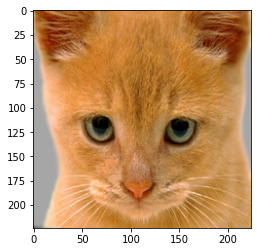

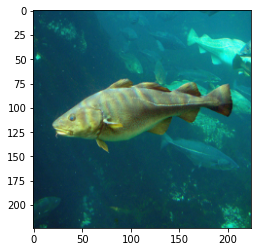

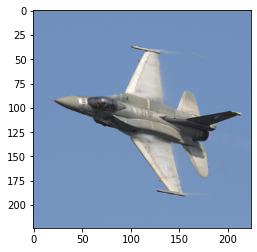

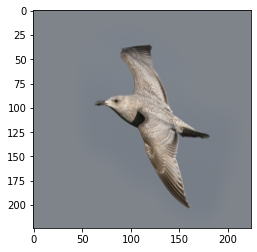

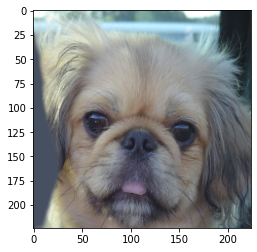

In [17]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# image IO using PyTorch dataloader
# set up the transforms (make sure you convert numpy array to pytorch tensor)
transforms = []
transforms.append(Resize(224))
transforms.append(RandomNoise(0.1))
transforms.append(ToTensor())
comp_transforms = Compose(transforms)

# let us try a toy dataset
dataset = SimpleDataset('./data', file_ext='bmp', transforms=comp_transforms)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)

# loop over the data set
for batch_idx, (imgs, labels) in enumerate(data_loader):
    print(imgs.shape)
    print(labels)
    for img_idx, img in enumerate(imgs):
        vis_img = img.permute(1, 2, 0).numpy().clip(0.0, 1.0)
        print(np.ptp(img.flatten()), np.ptp(vis_img.flatten()))
        #vis_img = (255 * vis_img).astype(np.uint8)
        plt.figure(); plt.imshow(vis_img)
        save_image('../results/loader_outputs_{:d}-{:d}.jpg'.format(batch_idx, img_idx), vis_img)